# Demo Notebook

In [5]:
import streamlit as st
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import torch as t
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

from interpretathon import X, get_cosine_similarity, get_dot_product

## Load the Model

In [6]:
MODEL_NAME = "gpt2-small"

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu") #If Mac, you can use "mps"
t.set_default_device(device)
saes, sparsities = get_gpt2_res_jb_saes()
gpt2_small: HookedTransformer = HookedTransformer.from_pretrained(MODEL_NAME)

x = X(gpt2_small, saes)

 92%|█████████▏| 12/13 [00:07<00:00,  1.71it/s]

(…).hook_resid_post/sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

(…).11.hook_resid_post/sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

100%|██████████| 13/13 [00:35<00:00,  2.70s/it]


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

c:\Users\kitten\Documents\code\interpretathon\venv\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kitten\.cache\huggingface\hub\models--gpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


## User Input

In [19]:
user_prompt = "This movie is amazing! The best I have ever seen"
feature_name = ["8.23510"]
use_dot = False   # metric to use, if True we use 'dot product' otherwise cosine similarity

### Run the code!

In [20]:
func = get_dot_product if use_dot else get_cosine_similarity

layers = range(x.model.cfg.n_layers)
prompt_tok = x.model.to_str_tokens(user_prompt)
    

data = x.run(x.model.to_tokens(user_prompt), func, x.get_feature_from_name(feature_name).to(device)).detach().cpu()
assert tuple(data.shape) == (len(prompt_tok), len(layers))

## Display the results

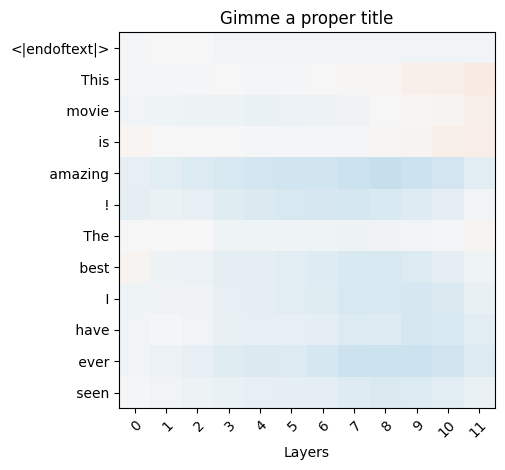

In [25]:
%matplotlib inline
fig, ax = plt.subplots()
if use_dot:
    #Todo, find min/max for dot product and provide as args to scale colour map
    im = ax.imshow(data)    
else:
    im = ax.imshow(data, vmin=-1, vmax=1, cmap='RdBu')
    
ax.set_xticks(np.arange(len(layers)), labels=layers)
ax.set_xlabel("Layers")
ax.set_yticks(np.arange(len(prompt_tok)), labels=prompt_tok)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
#for i in range(len(prompt_tok)):
#    for j in range(len(layers)):
#        text = ax.text(j, i, data[i, j],
#                    ha="center", va="center", color="w")
    
title = f"Activations of the prompt for feature '{feature_name}', measured with {'dot product' if use_dot else 'cosign similarity'}"
ax.set_title("Gimme a proper title")
fig.tight_layout()